In [1]:
import pandas as pd
import numpy as np
from scipy import stats


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# import shap #  Cannot install on Python version 3.13.0; only versions >=3.9,<3.13 are supported.

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

import joblib

### Read data set with UQS and CQMs

In [2]:
# train_df = pd.read_csv('C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\raw_scores.csv', sep=';')
train_df = pd.read_csv('C:\\Users\\admin\\Desktop\\VGGFace2-200k-all.csv', sep=';')
# train_df = pd.read_csv('C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\Flickr-0to9999.csv', sep=';')
# train_df = pd.read_csv('C:\\Users\\admin\\source\\repos\\RandomForestUQS\\combined_files.csv', sep=';')
# train_df = pd.read_csv('C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\Flickr-only.csv', sep=';')

# raw_df = pd.read_csv('C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\LFW_scores.csv', sep=';')
# raw_copy_df = raw_df

# specific_dataset_df = pd.read_csv("C:\\Users\\admin\\source\\repos\\HelperScripts\\output_files\\VGGFace-200k-431-502.csv", sep=';')

C:\Users\admin\AppData\Local\Temp\ipykernel_17100\3523667586.py:2: DtypeWarning: Columns (15,43) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('C:\\Users\\admin\\Desktop\\VGGFace2-200k-all.csv', sep=';')


In [3]:
# specific_dataset_df.head()

### Inspect data

In [4]:
#train_df.columns

In [5]:
train_df.describe()

,UnifiedQualityScore,BackgroundUniformity,IlluminationUniformity,LuminanceMean,LuminanceVariance,UnderExposurePrevention,OverExposurePrevention,DynamicRange,Sharpness,CompressionArtifacts,...,LeftwardCropOfTheFaceImage.scalar,RightwardCropOfTheFaceImage.scalar,MarginAboveOfTheFaceImage.scalar,MarginBelowOfTheFaceImage.scalar,HeadPoseYaw.scalar,HeadPosePitch.scalar,HeadPoseRoll.scalar,ExpressionNeutrality.scalar,NoHeadCoverings.scalar,Unnamed: 57
count,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,195788.000000,195788.000000,197684.000000,197684.000000,197684.000000,...,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,0.0
mean,21.231196,80.664214,0.411592,0.262675,0.022222,0.211277,0.000570,6.779410,39.379429,0.838543,...,99.949283,99.952181,49.640062,47.061239,86.040292,95.182974,95.729143,46.441513,91.646405,NaN
std,3.933268,74.322003,0.218670,0.116430,0.016821,0.209541,0.008520,0.629621,18.780816,0.076957,...,2.101427,2.008245,33.027875,23.085901,20.928868,10.167331,10.403484,28.569081,24.834834,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-50.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN
25%,18.226044,28.511613,0.242798,0.176984,0.010652,0.059145,0.000000,6.488656,42.000000,0.795383,...,100.000000,100.000000,16.000000,31.000000,82.000000,95.000000,96.000000,19.000000,100.000000,NaN
50%,21.227950,61.484994,0.427597,0.252320,0.018125,0.133240,0.000000,6.900752,47.000000,0.858716,...,100.000000,100.000000,55.000000,49.000000,96.000000,98.000000,99.000000,41.000000,100.000000,NaN
75%,24.228010,110.766834,0.590830,0.336969,0.028969,0.296119,0.000000,7.209606,47.000000,0.895513,...,100.000000,100.000000,80.000000,64.000000,99.000000,100.000000,100.000000,72.000000,100.000000,NaN
max,35.189240,2056.000000,1.000000,0.868540,0.189381,1.000000,0.660669,7.960028,50.000000,0.997724,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000,100.000000,NaN


In [6]:
train_df.dtypes

Filename                               object
UnifiedQualityScore                   float64
BackgroundUniformity                  float64
IlluminationUniformity                float64
LuminanceMean                         float64
LuminanceVariance                     float64
UnderExposurePrevention               float64
OverExposurePrevention                float64
DynamicRange                          float64
Sharpness                               int64
CompressionArtifacts                  float64
NaturalColour                         float64
SingleFacePresent                     float64
EyesOpen                              float64
MouthClosed                           float64
EyesVisible                            object
MouthOcclusionPrevention              float64
FaceOcclusionPrevention               float64
InterEyeDistance                      float64
HeadSize                              float64
LeftwardCropOfTheFaceImage            float64
RightwardCropOfTheFaceImage       

In [7]:
non_float_cells = train_df[train_df['EyesVisible'].apply(lambda x: x == '-nan(ind)')]

print(non_float_cells["EyesVisible"])

# OLD:
# # Remove rows where EyesVisible measure computation has failed 
# train_df = train_df[~train_df['EyesVisible'].apply(lambda x: x == '-nan(ind)')]

def convert_nanind_to_0(value):
    if value == '-nan(ind)':
        return 0
    else:
        return value

# Set EyesVisible.scalar score to the lowest value of 0
train_df['EyesVisible.scalar'] = train_df['EyesVisible.scalar'].apply(lambda x: convert_nanind_to_0(x))
train_df['EyesVisible.scalar'] = int(train_df['EyesVisible.scalar'])


# #also do it for the file to predict on
# test_what_we_remove = specific_dataset_df[specific_dataset_df['EyesVisible'].apply(lambda x: x == '-nan(ind)')]
# test_missing = test_what_we_remove[test_what_we_remove['Filename'].apply(lambda x: '45-0252_03' in x)]
# print(test_what_we_remove['Filename'])
# print(test_missing)
# print(len(test_what_we_remove))
# specific_dataset_df = specific_dataset_df[~specific_dataset_df['EyesVisible'].apply(lambda x: x == '-nan(ind)')]



813       -nan(ind)
5943      -nan(ind)
6210      -nan(ind)
6293      -nan(ind)
8913      -nan(ind)
            ...    
192979    -nan(ind)
193426    -nan(ind)
193610    -nan(ind)
193715    -nan(ind)
194407    -nan(ind)
Name: EyesVisible, Length: 167, dtype: object


In [8]:
# test_missing

In [9]:
# What is z-score exactly again?
#stats.zscore(train_df['MarginBelowOfTheFaceImage']).sort_values().tail(10)

In [10]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))

,0
Unnamed: 57,197517
UnderExposurePrevention,1875
OverExposurePrevention,1875
UnifiedQualityScore,0
BackgroundUniformity,0
Filename,0
LuminanceVariance,0
LuminanceMean,0
DynamicRange,0
IlluminationUniformity,0


In [11]:
train_df['EyesVisible.scalar'].unique()
# Unique can help identify nan values 
#UnderExposurePrevention.scalar does not have nan but has -1. Maybe same with OverExposurePrevention, check.
# Use .fillna to fill nan values

array(['100', '99', '97', '95', '96', '98', '91', '87', '92', '88', '86',
       '93', '89', '82', '94', '55', '79', '54', '42', '90', '63', '83',
       '68', '84', '85', '47', '0', '72', '1', '33', '60', '56', '59',
       '66', '62', '78', '8', '4', '52', '21', '61', '2', '31', '40',
       '80', '5', '71', '41', '27', '26', '3', '6', '73', '23', '81',
       '75', '77', '7', '10', '16', '38', '15', '46', '29', '12', '30',
       '43', '36', '19', '22', '44', '53', '51', '25', '74', '45', '48',
       '69', '70', '76', '67', '64', '65', '39', '58', '50', '35', '11',
       '9', '57', '32', '28', '49', '13', '-1', '37', '14', '24', '20',
       '18', '17', '34', 100, 97, 99, 92, 98, 95, 96, 87, 93, 84, 94, 79,
       86, 85, 91, 69, 83, 89, 81, 90, 76, 57, 0, 60, 61, 80, 78, 82, 68,
       64, 39, 48, 24, 34, 73, 70, 77, 35, 74, 4], dtype=object)

In [12]:
#specific correlations between two CQMs
#train_df['MouthClosed'].corr(train_df['ExpressionNeutrality'])

## Choose to work with native or scalar scores and measures

In [13]:
# Save dataframe with filenames before dropping columns
# filenames = train_df["Filename"]


# filenames_specific_dataset = specific_dataset_df["Filename"]



In [14]:
# Predict scalar UQS based on scalar CQMs
train_df = train_df.drop(columns=['Filename', 'UnifiedQualityScore', 'BackgroundUniformity',
       'IlluminationUniformity', 'LuminanceMean', 'LuminanceVariance',
       'UnderExposurePrevention', 'OverExposurePrevention', 'DynamicRange',
       'Sharpness', 'CompressionArtifacts', 'NaturalColour',
       'SingleFacePresent', 'EyesOpen', 'MouthClosed', 'EyesVisible',
       'MouthOcclusionPrevention', 'FaceOcclusionPrevention',
       'InterEyeDistance', 'HeadSize', 'LeftwardCropOfTheFaceImage',
       'RightwardCropOfTheFaceImage', 'MarginAboveOfTheFaceImage',
       'MarginBelowOfTheFaceImage', 'HeadPoseYaw', 'HeadPosePitch',
       'HeadPoseRoll', 'ExpressionNeutrality', 'NoHeadCoverings', 'Unnamed: 57'])
# raw_df = raw_df.drop(columns=['Filename', 'UnifiedQualityScore', 'BackgroundUniformity',
#        'IlluminationUniformity', 'LuminanceMean', 'LuminanceVariance',
#        'UnderExposurePrevention', 'OverExposurePrevention', 'DynamicRange',
#        'Sharpness', 'CompressionArtifacts', 'NaturalColour',
#        'SingleFacePresent', 'EyesOpen', 'MouthClosed', 'EyesVisible',
#        'MouthOcclusionPrevention', 'FaceOcclusionPrevention',
#        'InterEyeDistance', 'HeadSize', 'LeftwardCropOfTheFaceImage',
#        'RightwardCropOfTheFaceImage', 'MarginAboveOfTheFaceImage',
#        'MarginBelowOfTheFaceImage', 'HeadPoseYaw', 'HeadPosePitch',
#        'HeadPoseRoll', 'ExpressionNeutrality', 'NoHeadCoverings', 'Unnamed: 57'])
# specific_dataset_df = specific_dataset_df.drop(columns=['Filename', 'UnifiedQualityScore', 'BackgroundUniformity',
#        'IlluminationUniformity', 'LuminanceMean', 'LuminanceVariance',
#        'UnderExposurePrevention', 'OverExposurePrevention', 'DynamicRange',
#        'Sharpness', 'CompressionArtifacts', 'NaturalColour',
#        'SingleFacePresent', 'EyesOpen', 'MouthClosed', 'EyesVisible',
#        'MouthOcclusionPrevention', 'FaceOcclusionPrevention',
#        'InterEyeDistance', 'HeadSize', 'LeftwardCropOfTheFaceImage',
#        'RightwardCropOfTheFaceImage', 'MarginAboveOfTheFaceImage',
#        'MarginBelowOfTheFaceImage', 'HeadPoseYaw', 'HeadPosePitch',
#        'HeadPoseRoll', 'ExpressionNeutrality', 'NoHeadCoverings', 'Unnamed: 57'])

# Also drop CQMs that are not in landmarked region
# train_df = train_df.drop(columns=['BackgroundUniformity.scalar', 'SingleFacePresent.scalar',
#        'HeadSize.scalar', 'LeftwardCropOfTheFaceImage.scalar',
#        'RightwardCropOfTheFaceImage.scalar', 'MarginAboveOfTheFaceImage.scalar',
#        'MarginBelowOfTheFaceImage.scalar',  'NoHeadCoverings.scalar'])
# raw_df = raw_df.drop(columns=['BackgroundUniformity.scalar', 'SingleFacePresent.scalar',
#        'HeadSize.scalar', 'LeftwardCropOfTheFaceImage.scalar',
#        'RightwardCropOfTheFaceImage.scalar', 'MarginAboveOfTheFaceImage.scalar',
#        'MarginBelowOfTheFaceImage.scalar',  'NoHeadCoverings.scalar'])

# Predict native UQS based on native CQMs
# train_df = train_df.drop(columns=['Filename', 'UnifiedQualityScore.scalar', 'BackgroundUniformity.scalar',
#        'IlluminationUniformity.scalar', 'LuminanceMean.scalar', 'LuminanceVariance.scalar',
#        'UnderExposurePrevention.scalar', 'OverExposurePrevention.scalar', 'DynamicRange.scalar',
#        'Sharpness.scalar', 'CompressionArtifacts.scalar', 'NaturalColour.scalar',
#        'SingleFacePresent.scalar', 'EyesOpen.scalar', 'MouthClosed.scalar', 'EyesVisible.scalar',
#        'MouthOcclusionPrevention.scalar', 'FaceOcclusionPrevention.scalar',
#        'InterEyeDistance.scalar', 'HeadSize.scalar', 'LeftwardCropOfTheFaceImage.scalar',
#        'RightwardCropOfTheFaceImage.scalar', 'MarginAboveOfTheFaceImage.scalar',
#        'MarginBelowOfTheFaceImage.scalar', 'HeadPoseYaw.scalar', 'HeadPosePitch.scalar',
#        'HeadPoseRoll.scalar', 'ExpressionNeutrality.scalar', 'NoHeadCoverings.scalar', 'Unnamed: 57'])
# raw_df = raw_df.drop(columns=['Filename', 'UnifiedQualityScore.scalar', 'BackgroundUniformity.scalar',
#        'IlluminationUniformity.scalar', 'LuminanceMean.scalar', 'LuminanceVariance.scalar',
#        'UnderExposurePrevention.scalar', 'OverExposurePrevention.scalar', 'DynamicRange.scalar',
#        'Sharpness.scalar', 'CompressionArtifacts.scalar', 'NaturalColour.scalar',
#        'SingleFacePresent.scalar', 'EyesOpen.scalar', 'MouthClosed.scalar', 'EyesVisible.scalar',
#        'MouthOcclusionPrevention.scalar', 'FaceOcclusionPrevention.scalar',
#        'InterEyeDistance.scalar', 'HeadSize.scalar', 'LeftwardCropOfTheFaceImage.scalar',
#        'RightwardCropOfTheFaceImage.scalar', 'MarginAboveOfTheFaceImage.scalar',
#        'MarginBelowOfTheFaceImage.scalar', 'HeadPoseYaw.scalar', 'HeadPosePitch.scalar',
#        'HeadPoseRoll.scalar', 'ExpressionNeutrality.scalar', 'NoHeadCoverings.scalar', 'Unnamed: 57'])


# Predict scalar UQS based on native CQMs
# train_df = train_df.drop(columns=['Filename', 'UnifiedQualityScore', 'BackgroundUniformity.scalar',
#        'IlluminationUniformity.scalar', 'LuminanceMean.scalar', 'LuminanceVariance.scalar',
#        'UnderExposurePrevention.scalar', 'OverExposurePrevention.scalar', 'DynamicRange.scalar',
#        'Sharpness.scalar', 'CompressionArtifacts.scalar', 'NaturalColour.scalar',
#        'SingleFacePresent.scalar', 'EyesOpen.scalar', 'MouthClosed.scalar', 'EyesVisible.scalar',
#        'MouthOcclusionPrevention.scalar', 'FaceOcclusionPrevention.scalar',
#        'InterEyeDistance.scalar', 'HeadSize.scalar', 'LeftwardCropOfTheFaceImage.scalar',
#        'RightwardCropOfTheFaceImage.scalar', 'MarginAboveOfTheFaceImage.scalar',
#        'MarginBelowOfTheFaceImage.scalar', 'HeadPoseYaw.scalar', 'HeadPosePitch.scalar',
#        'HeadPoseRoll.scalar', 'ExpressionNeutrality.scalar', 'NoHeadCoverings.scalar', 'Unnamed: 57'])
# raw_df = raw_df.drop(columns=['Filename', 'UnifiedQualityScore', 'BackgroundUniformity.scalar',
#        'IlluminationUniformity.scalar', 'LuminanceMean.scalar', 'LuminanceVariance.scalar',
#        'UnderExposurePrevention.scalar', 'OverExposurePrevention.scalar', 'DynamicRange.scalar',
#        'Sharpness.scalar', 'CompressionArtifacts.scalar', 'NaturalColour.scalar',
#        'SingleFacePresent.scalar', 'EyesOpen.scalar', 'MouthClosed.scalar', 'EyesVisible.scalar',
#        'MouthOcclusionPrevention.scalar', 'FaceOcclusionPrevention.scalar',
#        'InterEyeDistance.scalar', 'HeadSize.scalar', 'LeftwardCropOfTheFaceImage.scalar',
#        'RightwardCropOfTheFaceImage.scalar', 'MarginAboveOfTheFaceImage.scalar',
#        'MarginBelowOfTheFaceImage.scalar', 'HeadPoseYaw.scalar', 'HeadPosePitch.scalar',
#        'HeadPoseRoll.scalar', 'ExpressionNeutrality.scalar', 'NoHeadCoverings.scalar', 'Unnamed: 57'])


## Feature engineering

In [15]:
# train_df['MeanCropScore'] = (train_df['LeftwardCropOfTheFaceImage'] + train_df['RightwardCropOfTheFaceImage']) / 2
# train_df['MeanCropScore.scalar'] = (train_df['LeftwardCropOfTheFaceImage.scalar'] + train_df['RightwardCropOfTheFaceImage.scalar']) / 2

In [16]:
# train_df['MeanCropScore'].head(15)
# train_df['MeanCropScore.scalar'].head(15)

In [17]:
# train_df['MeanMarginScore'] = (train_df['MarginBelowOfTheFaceImage'] + train_df['MarginAboveOfTheFaceImage']) / 2
# train_df['MeanMarginScore.scalar'] = (train_df['MarginBelowOfTheFaceImage.scalar'] + train_df['MarginAboveOfTheFaceImage.scalar']) / 2


In [18]:
# train_df['MeanMarginScore'].head(15)
# train_df['MeanMarginScore.scalar'].head(15)

# Only keep top X features

In [19]:

train_df = train_df.drop(columns=['HeadSize.scalar',
                                  'LeftwardCropOfTheFaceImage.scalar',
                                  'CompressionArtifacts.scalar',
                                  'UnderExposurePrevention.scalar',
                                  'SingleFacePresent.scalar',
                                  'OverExposurePrevention.scalar',
                                  'MouthOcclusionPrevention.scalar',
                                  'FaceOcclusionPrevention.scalar'

                                  ])


# 'BackgroundUniformity.scalar',
# 'IlluminationUniformity.scalar',
# 'LuminanceMean.scalar',
# 'LuminanceVariance.scalar',
# 'UnderExposurePrevention.scalar',
# 'OverExposurePrevention.scalar',
# 'DynamicRange.scalar',
# 'Sharpness.scalar',
# 'CompressionArtifacts.scalar',
# 'NaturalColour.scalar',
# 'SingleFacePresent.scalar',
# 'EyesOpen.scalar',
# 'MouthClosed.scalar',
# 'EyesVisible.scalar',
# 'MouthOcclusionPrevention.scalar',
# 'FaceOcclusionPrevention.scalar',
# 'InterEyeDistance.scalar',
# 'HeadSize.scalar',
# 'LeftwardCropOfTheFaceImage.scalar',
# 'RightwardCropOfTheFaceImage.scalar',
# 'MarginAboveOfTheFaceImage.scalar',
# 'MarginBelowOfTheFaceImage.scalar',
# 'HeadPoseYaw.scalar',
# 'HeadPosePitch.scalar',
# 'HeadPoseRoll.scalar',
# 'ExpressionNeutrality.scalar',
# 'NoHeadCoverings.scalar',

## Check correlations and drop some correlated features

<Axes: >

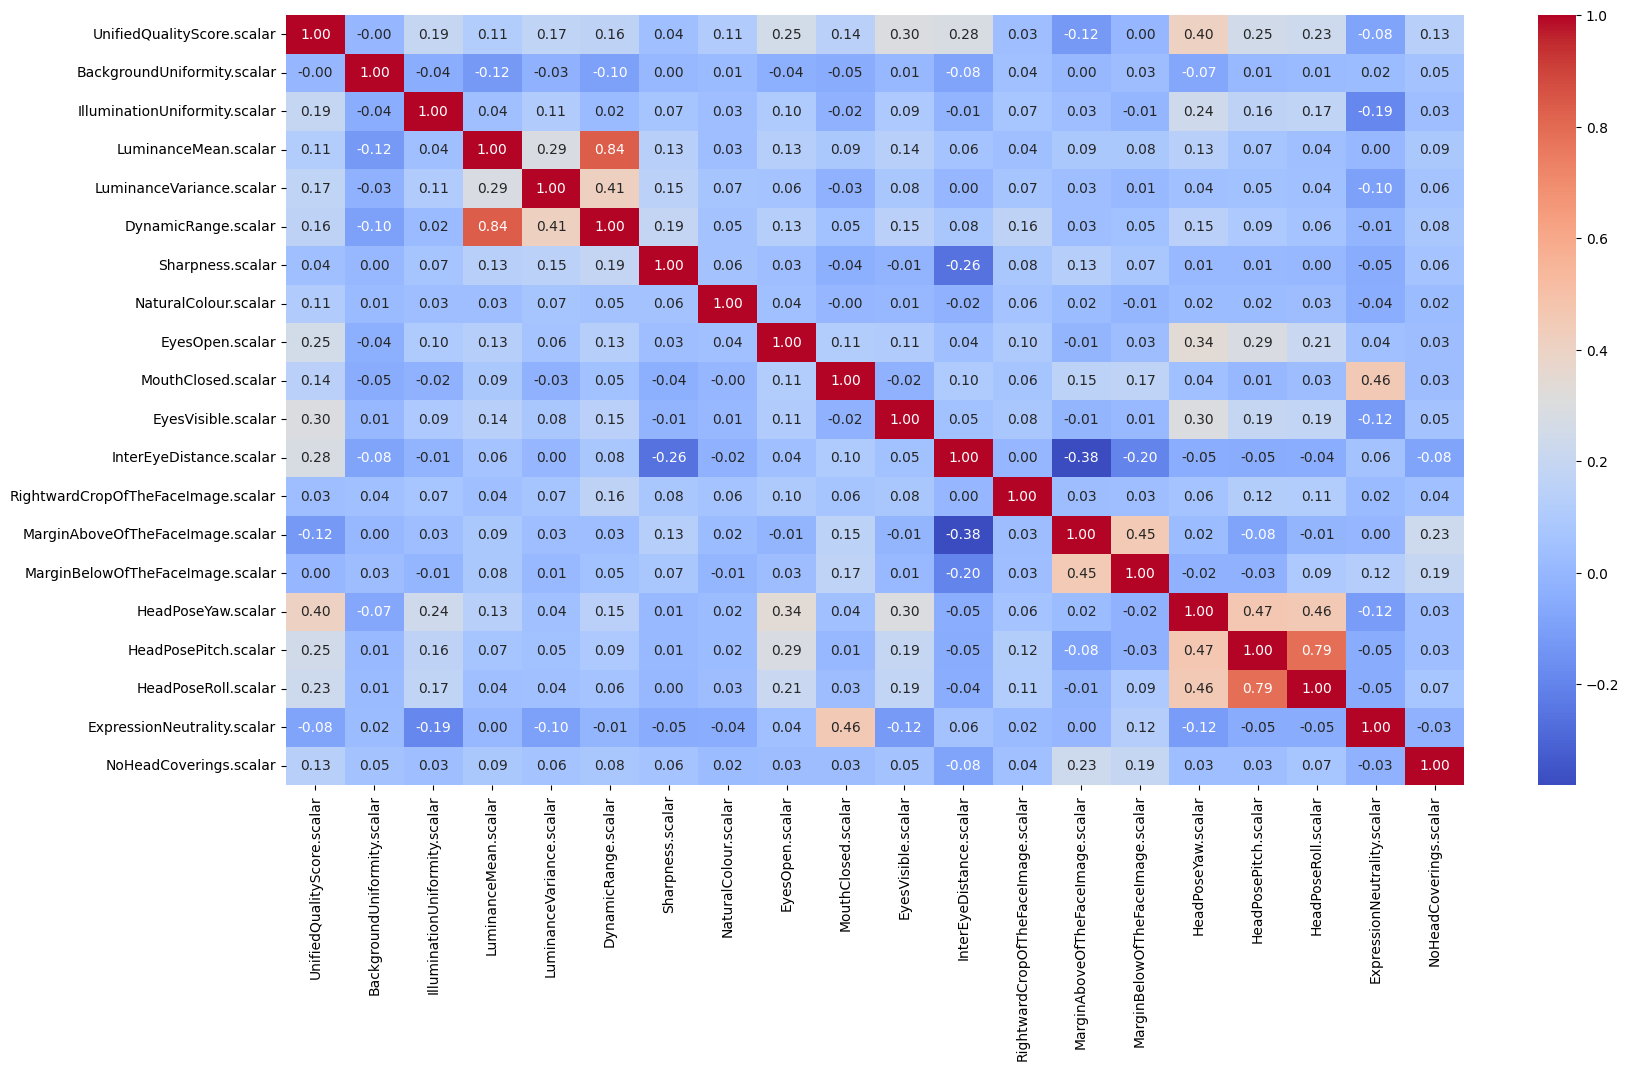

In [20]:
correlations = train_df.corr()
plt.figure(figsize=(19,10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")

In [21]:
# FaceOcclusionPrevention or EyesVisible and MouthOcclusionPrevention?
# Remove ExpressionNeutrality or the ones it correlates with?
# train_df = train_df.drop(columns=['DynamicRange', 'HeadSize',
#                                   'LeftwardCropOfTheFaceImage', 'RightwardCropOfTheFaceImage', 
#                                   'MarginAboveOfTheFaceImage', 'MarginBelowOfTheFaceImage'])
# train_df = train_df.drop(columns=['DynamicRange.scalar', 'HeadSize.scalar',
#                                   'LeftwardCropOfTheFaceImage.scalar', 'RightwardCropOfTheFaceImage.scalar', 
#                                   'MarginAboveOfTheFaceImage.scalar', 'MarginBelowOfTheFaceImage.scalar'])

<Axes: >

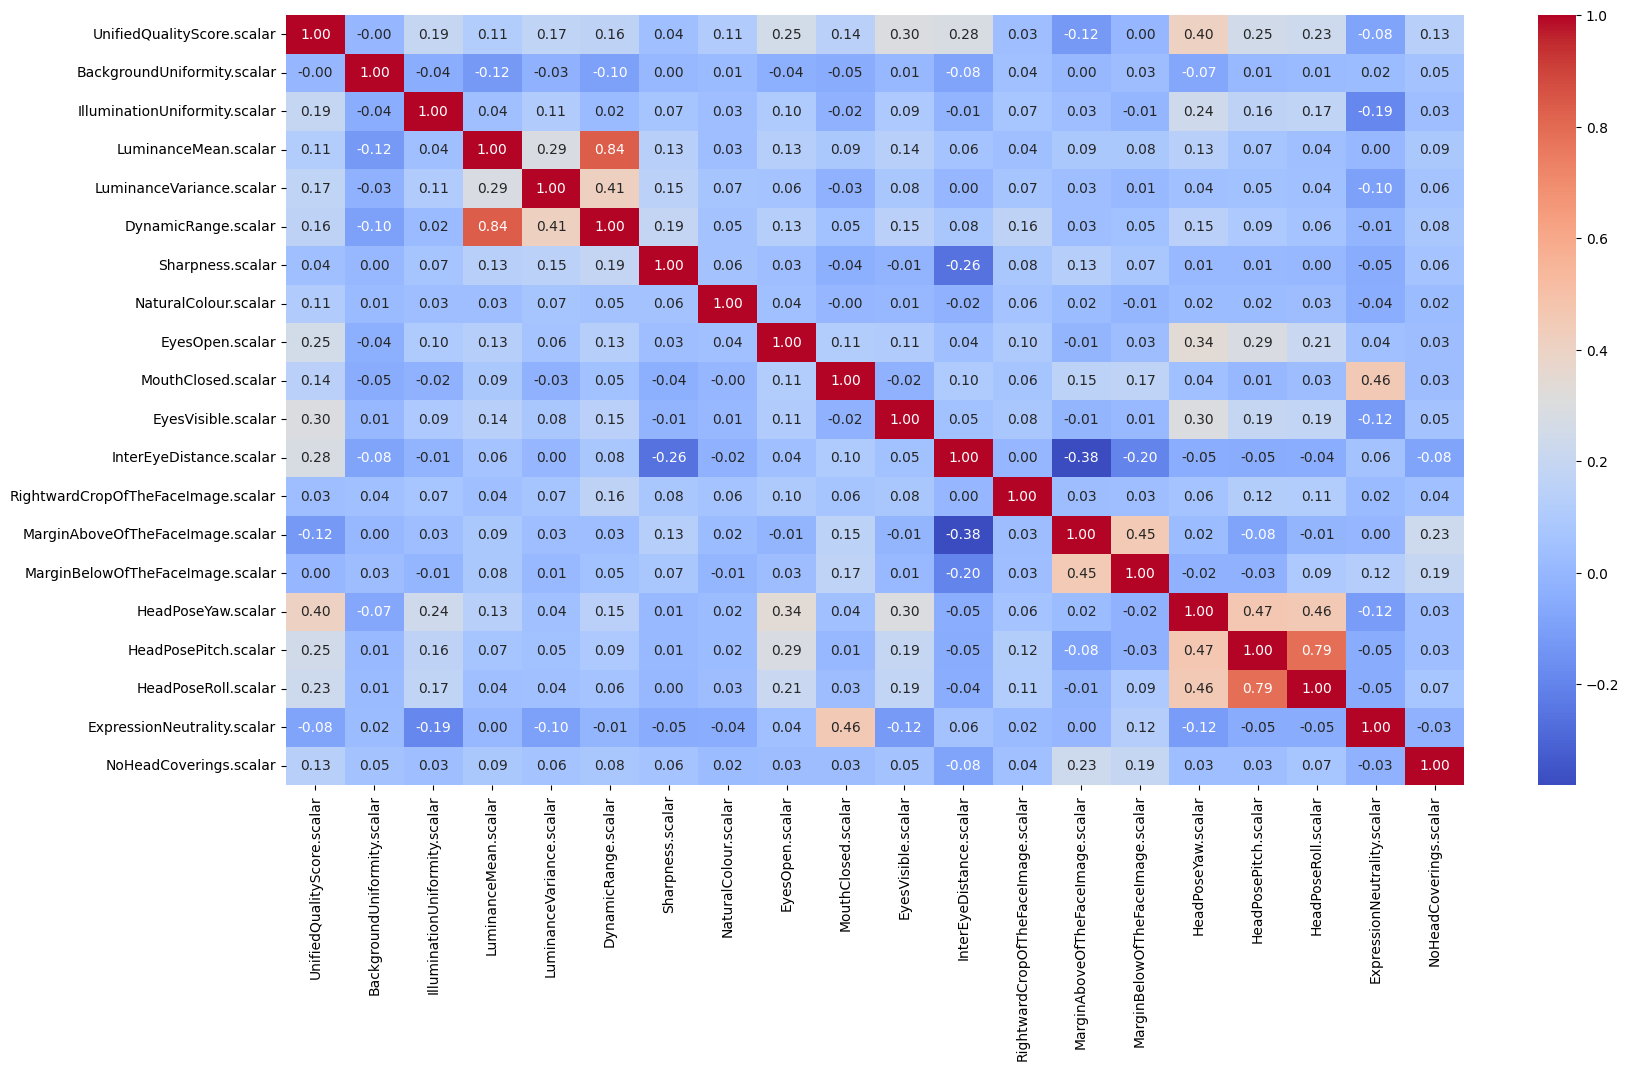

In [22]:
corr_after_drop = train_df.corr()
plt.figure(figsize=(19,10))
sns.heatmap(corr_after_drop, annot=True, cmap='coolwarm', fmt=".2f")

## UQS histogram

<Axes: xlabel='UnifiedQualityScore.scalar', ylabel='Count'>

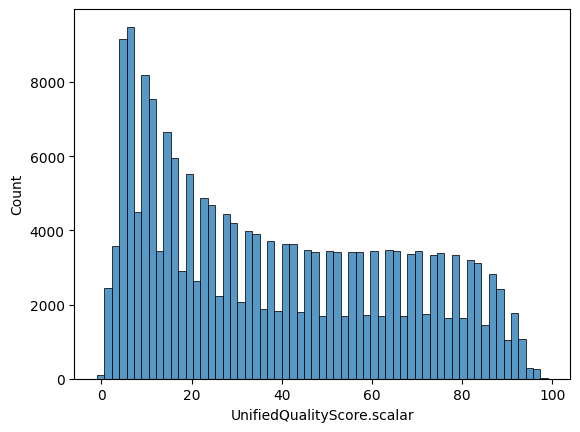

In [23]:
# sns.histplot(
#     train_df,
#     x=train_df['UnifiedQualityScore']
# )

sns.histplot(
    train_df,
    x=train_df['UnifiedQualityScore.scalar']
)

In [24]:
# Consider logarithmic on non-scalar scores, so UnifiedQualityScore for example 
# train_df['UnifiedQualityScore_Log'] = np.log1p(train_df['UnifiedQualityScore'])

In [25]:
column_names = train_df.select_dtypes(include=['int64', 'float64']).columns
# column_names = column_names.drop('UnifiedQualityScore')
column_names = column_names.drop('UnifiedQualityScore.scalar')

In [26]:
# Impute to fill missing values. Might not be necessary...
impute_and_scale_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [27]:
columns_transformed = ColumnTransformer(transformers=[
    ('num_p', impute_and_scale_pipeline, column_names)
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [28]:
preprocess_pipeline = Pipeline(steps=[
    ('preprocessing', columns_transformed)
])

In [29]:
# X = train_df.drop('UnifiedQualityScore', axis=1)
# y = train_df['UnifiedQualityScore']
# X_raw = raw_df.drop('UnifiedQualityScore', axis=1)
# y_raw = raw_df['UnifiedQualityScore']

X = train_df.drop('UnifiedQualityScore.scalar', axis=1)
y = train_df['UnifiedQualityScore.scalar']
# X_raw = raw_df.drop('UnifiedQualityScore.scalar', axis=1)
# y_raw = raw_df['UnifiedQualityScore.scalar']
# X_specific_dataset = specific_dataset_df.drop('UnifiedQualityScore.scalar', axis=1)
# y_specific_dataset = specific_dataset_df['UnifiedQualityScore.scalar']

In [30]:
X_preprocessed = preprocess_pipeline.fit_transform(X)
# X_raw_preprocessed = preprocess_pipeline.fit_transform(X_raw)
# X_specific_dataset_preprocessed = preprocess_pipeline.fit_transform(X_specific_dataset)

# X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(X_preprocessed, y, filenames, test_size=0.2, random_state=36)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=36)

# Train

### ==== Remember to drop the features with lowest importance. Higher up in this file. ====

#### Random Forest Regressor parameters

In [31]:
# n_estimators = 1000
# max_depth = 50
# max_features = 6
# min_samples_leaf = 2
# min_samples_split = 4
# bootstrap = False

n_estimators = 200
max_depth = 30
max_features = 6
min_samples_leaf = 4
min_samples_split = 8
bootstrap = False

In [32]:

grid_parameters = {'n_estimators': [n_estimators],
                'max_depth': [max_depth],
                'max_features': [max_features],
                'min_samples_leaf': [min_samples_leaf],
                'min_samples_split': [min_samples_split],
                'bootstrap': [bootstrap]}

In [33]:
random_forest_regressor = RandomForestRegressor(random_state=36)

In [34]:
# Not really running a grid search, it was just an easy way with my existing code to run cross validation.
random_forest_cross_val = GridSearchCV(random_forest_regressor, grid_parameters, cv=5, n_jobs=-1)

In [35]:
random_forest_cross_val.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=36), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [30],
                         'max_features': [6], 'min_samples_leaf': [4],
                         'min_samples_split': [8], 'n_estimators': [200]})

In [36]:
random_forest_cross_val.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=30, max_features=6,
                      min_samples_leaf=4, min_samples_split=8, n_estimators=200,
                      random_state=36)

In [37]:
random_forest_cross_val.best_params_

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 200}

In [38]:
results_of_cv = pd.DataFrame(random_forest_cross_val.cv_results_)
results_of_cv.to_csv("./results_of_RandomizedSearchCVs/results_of_ablation_cv.csv", sep=';')

In [39]:
print(random_forest_cross_val.n_features_in_)
print(train_df.columns)

19
Index(['UnifiedQualityScore.scalar', 'BackgroundUniformity.scalar',
       'IlluminationUniformity.scalar', 'LuminanceMean.scalar',
       'LuminanceVariance.scalar', 'DynamicRange.scalar', 'Sharpness.scalar',
       'NaturalColour.scalar', 'EyesOpen.scalar', 'MouthClosed.scalar',
       'EyesVisible.scalar', 'InterEyeDistance.scalar',
       'RightwardCropOfTheFaceImage.scalar',
       'MarginAboveOfTheFaceImage.scalar', 'MarginBelowOfTheFaceImage.scalar',
       'HeadPoseYaw.scalar', 'HeadPosePitch.scalar', 'HeadPoseRoll.scalar',
       'ExpressionNeutrality.scalar', 'NoHeadCoverings.scalar'],
      dtype='object')


In [40]:
model_filename = "./models/rfr_UQS_scalar_to_scalar_Ablation_Top_X_features_VGGFace-200k.pkl"

In [41]:

joblib.dump(random_forest_cross_val.best_estimator_, model_filename)

['./models/rfr_UQS_scalar_to_scalar_Ablation_Top_X_features_VGGFace-200k.pkl']

In [42]:
load_saved_model_test = joblib.load(model_filename)

In [43]:
y_pred_from_saved_model = load_saved_model_test.predict(X_test)

In [44]:
y_pred_from_saved_model

array([69.69504349, 52.39395366, 63.54380821, ..., 11.93996429,
       13.12411905, 74.03963978])